## Predicted ionospheric range delay (for different SAR bands and range bandwidths)


$$\delta\rho_{iono} = - \frac{K}{f_{0}^2} \frac{TEC}{cos(\theta)}$$

where $K=40.31 m^3s^{-2}$, $\theta$ is the look angle, $f_0$ is the radar carrier frequency.

In [1]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt, ticker
plt.rcParams.update({'font.size': 12})

work_dir = os.path.expanduser('~/Papers/2021_Geolocation/figs_src')
os.chdir(work_dir)
print('Go to directory:', work_dir)

Go to directory: /Users/yunjunz/Papers/2021_Geolocation/figs_src


In [2]:
# constants
K = 40.31
Re = 6371e3   # earth radius in meters
c = 299792458 # speed of light in m / s

# SAR parameters
bnames = ['L', 'S', 'C', 'X']
freqs = [1.257e9, 3.2e9, 5.405e9, 9.65e9]  #carrier frequency for NISAR-L/-S, S1 and TSX
rg_bandwidths = [20e6, 40e6, 80e6]         #range bandwidth in Hz
look_angle = 37 * (np.pi / 180.)           #NISAR look angle in rad
height = 747e3                             #NISAR altitude in meters

# look angle -> inc angle
inc_angle = np.arcsin(np.sin(look_angle) * (Re+height)/Re)

def vtec2range_delay(vtec, inc_angle, freq):
    # convert to TEC in LOS based on equation (3) in Chen and Zebker (2012)
    los_tec = vtec / np.cos(inc_angle)
    # calculate range delay based on equation (1) in Chen and Zebker (2012)
    range_delay = (los_tec * 1e16 * K / (freq**2)).astype(np.float32)
    return range_delay


# Numbers for 20 TECU
TEC = 20
rg_delay = vtec2range_delay(TEC, inc_angle, freqs[0])
rg_delay_bw20 = rg_delay / (c / 20e6 / 2)
rg_delay_bw40 = rg_delay / (c / 40e6 / 2)
print('20 TECU -> {:.1f} m delay -> {:.1f} / {:.1f} pixels at 20 / 40 MHz'.format(rg_delay, rg_delay_bw20, rg_delay_bw40))

20 TECU -> 6.9 m delay -> 0.9 / 1.8 pixels at 20 / 40 MHz


## Plot

save figure to file /Users/yunjunz/Papers/2021_Geolocation/figs_src/docs/TEC2rgDelay_pred.png


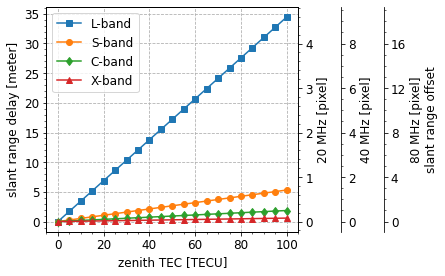

In [3]:
TEC = np.linspace(0, 100, 21)          #iono in TECU

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[7, 4])

## range delay in meters
for i, (bname, freq, marker) in enumerate(zip(bnames, freqs, ['s-', 'o-', 'd-', '^-'])):
    rg_delay_m = vtec2range_delay(TEC, inc_angle, freq)
    ax.plot(TEC, rg_delay_m, marker, label='{}-band'.format(bname))

# axis format
#ax.set_xlim(0, 100)
#ax.set_ylim(-2, 28)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_xlabel('zenith TEC [TECU]')
ax.set_ylabel('slant range delay [meter]')
ax.legend()
ax.grid('on', linestyle='--')

## range delay in pixels
for i, (rg_bandwidth, ystep) in enumerate(zip(rg_bandwidths, [1, 2, 4])):
    # add y-axis
    ax2 = ax.twinx()
    ax2.spines['right'].set_position(('axes', 1.0+0.17*i))
    ax2.tick_params(which='both', axis='y')
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(ystep))
    ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    # ylabel
    label = '{:.0f} MHz [pixel]'.format(rg_bandwidth/1e6)
    if i == len(rg_bandwidths) - 1:
        label += '\nslant range offset'
    ax2.set_ylabel(label)

    # ylim sync btw. ax and ax2
    rg_pixel_size = c / rg_bandwidth / 2
    #rg_delay_p = rg_delay_m / rg_pixel_size
    #ratio = ((np.max(rg_delay_p) - np.min(rg_delay_p)) / (np.max(rg_delay_m)   - np.min(rg_delay_m)))
    ratio = 1. / rg_pixel_size
    ax2.set_ylim(np.array(ax.get_ylim()) * ratio)
fig.tight_layout()

# output
out_fig = os.path.join(work_dir, 'docs/TEC2rgDelay_pred.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()